In [1]:
import os
import cv2
import yaml
import albumentations as A
import numpy as np
from matplotlib import pyplot as plt

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
# Load the data.yaml file
with open('archive/car/data.yaml', 'r') as file:
    data_yaml = yaml.safe_load(file)

print(data_yaml)

# Define paths
images_path = 'archive/car/train/images/'
labels_path = 'archive/car/train/labels/'

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 15, 'names': ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop'], 'roboflow': {'workspace': 'selfdriving-car-qtywx', 'project': 'self-driving-cars-lfjou', 'version': 6, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/6'}}


In [3]:
# Function to resize images
def resize_image(image, size=(416, 416)):
    return cv2.resize(image, size)

# Function to load and resize images
def load_and_resize_images(images_path, size=(416, 416)):
    images = []
    image_files = os.listdir(images_path)
    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            resized_image = resize_image(image, size)
            images.append(resized_image)
    return images

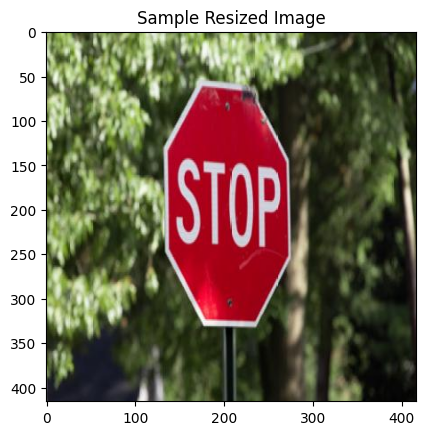

In [4]:
# Load and resize images
resized_images = load_and_resize_images(images_path)

# Display a sample resized image
plt.imshow(cv2.cvtColor(resized_images[0], cv2.COLOR_BGR2RGB))
plt.title("Sample Resized Image")
plt.show()

In [5]:
# Function to check and prepare labels
def load_labels(labels_path):
    labels = []
    label_files = os.listdir(labels_path)
    for label_file in label_files:
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as file:
            label = file.read()
            labels.append(label)
    return labels

# Load labels
labels = load_labels(labels_path)

# Print a sample label
print("Sample Label:", labels[0])

Sample Label: 1 0.4651442307692308 0.4254807692307692 0.03125 0.020432692307692308
1 0.5612980769230769 0.421875 0.03125 0.018028846153846152


In [6]:
#where we are going to store augmented images, helps prevent no overfitting
aug_images_path = 'archive/car/train/aug_images/'
aug_labels_path = 'archive/car/train/aug_labels/'

# Create directories for augmented data if they don't exist
os.makedirs(aug_images_path, exist_ok=True)
os.makedirs(aug_labels_path, exist_ok=True)

In [11]:
# Define augmentation pipeline
augmentation_pipeline = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.GaussNoise(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Function to read YOLO label file
def read_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
    if not lines:
        return np.empty((0, 5))  # Return an empty array with the correct shape if the file is empty
    
    labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # Skip lines that don't have exactly 5 elements
        class_id, x, y, w, h = map(float, parts)
        labels.append([class_id, x, y, w, h])
    return np.array(labels)

# Function to write YOLO label file
def write_yolo_labels(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(" ".join(map(str, label)) + '\n')

# Process each image and its corresponding label
for image_name in os.listdir(images_path):
    image_path = os.path.join(images_path, image_name)
    label_path = os.path.join(labels_path, os.path.splitext(image_name)[0] + '.txt')
    
    # Read image and labels
    image = cv2.imread(image_path)
    labels = read_yolo_labels(label_path)
    
    # Extract class labels and bounding boxes
    class_labels = labels[:, 0].astype(int).tolist()
    bboxes = labels[:, 1:].tolist()
    
    # Apply augmentation
    augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']

    #convert tuple to list if tuple
    if not isinstance(augmented_bboxes[0], list):
        augmented_bboxes = [list(bbox) for bbox in augmented_bboxes]
    
    augmented_labels = np.array([[class_labels[i]] + augmented_bboxes[i] for i in range(len(class_labels))])
    
    # Save augmented image and labels
    aug_image_path = os.path.join(aug_images_path, image_name)
    aug_label_path = os.path.join(aug_labels_path, os.path.splitext(image_name)[0] + '.txt')
    
    cv2.imwrite(aug_image_path, augmented_image)
    write_yolo_labels(aug_label_path, augmented_labels)

print("Data augmentation completed.")

IndexError: list index out of range